## SetUp

In [1]:
%%capture

def kaggleSetUp():
  !pip install kaggle
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir  ~/.kaggle
  !cp /content/drive/MyDrive/Kaggle/Kaggle_Credential/kaggle.json ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle config --list


kaggleSetUp()
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

## Import libraries

In [2]:
%%capture
!pip install tensorflow
!pip install keras
!pip --upgrade tensorflow


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix



In [4]:
train_directory = "/content/chest_xray/train"
test_directory = "/content/chest_xray/test"
val_directory = "//content/chest_xray/val"

In [5]:
print(os.listdir(train_directory))
print(os.listdir(test_directory))
print(os.listdir(val_directory))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [6]:
os.listdir(train_directory)[0]

'NORMAL'

In [7]:
labels = ["PNEUMONIA","NORMAL"]
labels

['PNEUMONIA', 'NORMAL']

In [8]:
def accessingfolder(directory):
    normal = os.path.join(directory,"NORMAL")
    pneumonia = os.path.join(directory,"PNEUMONIA")

    return normal,pneumonia

In [9]:
# Checking number of Sample

# for test_directory

test_normal , test_pneu = accessingfolder(test_directory)
print("Number of Normal in Test: ", len(os.listdir(test_normal)))
print("Number of Pneumonia in Test: ", len(os.listdir(test_pneu)))


# for train_directory
train_normal , train_pneu = accessingfolder(train_directory)
print("Number of Normal in Train: ", len(os.listdir(train_normal)))
print("Number of Pneumonia in Train: ", len(os.listdir(train_pneu)))

#for val_directory
val_normal , val_pneu = accessingfolder(val_directory)
print("Number of Normal in Val: ", len(os.listdir(val_normal)))
print("Number of Pneumonia in Val: ", len(os.listdir(val_pneu)))

Number of Normal in Test:  234
Number of Pneumonia in Test:  390
Number of Normal in Train:  1341
Number of Pneumonia in Train:  3875
Number of Normal in Val:  8
Number of Pneumonia in Val:  8


In [10]:
os.listdir(train_normal)[0]

'NORMAL2-IM-1096-0001-0001.jpeg'

In [11]:
sample_normal = os.listdir(train_normal)[0]
sample_pneu=os.listdir(train_pneu)[0]
print(sample_normal)

NORMAL2-IM-1096-0001-0001.jpeg


In [12]:
def printimage(df,sample):
    image =  os.path.join(df,sample) #chest_xray/train/normal/ + xyz.jpeg -> accessing Image
    img = cv2.imread(image)
    print("Shape of Image: ",img.shape)
    return plt.imshow(img)

Shape of Image:  (1291, 1674, 3)


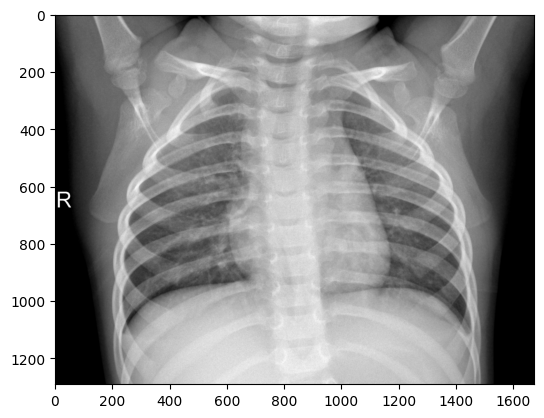

In [13]:
printimage(train_normal,sample_normal)

Shape of Image:  (504, 1040, 3)


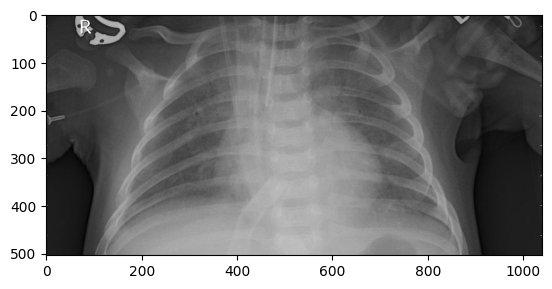

In [14]:
printimage(train_pneu,sample_pneu)

* Resizing the images by 180 x 180
* Storing images in X and their labels in y

In [15]:
def separation(directory, x, y):

    # iterating over normal and pneumonia (total 2 iteration)
    for i in labels:
        path = os.path.join(directory,i)

        for img in os.listdir(path):
            #read images
            current_image = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)

            if current_image is not None:
                resized_img = cv2.resize(current_image,(180,180))
                x.append(resized_img)
                y.append(labels.index(i))
    return x,y

* Validation set has 16 images,
* so we'll combine them in training set and split them by 80:20 ratio

In [16]:
X_train  = []
y_train  = []

X_test= []
y_test = []
X_train  , y_train = separation(train_directory, X_train , y_train )
X_test  , y_test = separation(test_directory, X_test, y_test )


X_train, y_train = separation(val_directory, X_train , y_train )

In [17]:
X_train , X_val , y_train , y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
type(X_train),type(y_train)

(list, list)

In [19]:
print("Training Images Count: " ,len(X_train),len(y_train)),
print("Val Images Count: ",len(X_val),len(y_val)),
print("Test Images Count: ",len(X_test),len(y_test))

Training Images Count:  4185 4185
Val Images Count:  1047 1047
Test Images Count:  624 624


In [20]:
from collections import Counter
counter = Counter(y_train)
print("Pneumonia Images:" ,counter[0]),
print("Normal Images:" ,counter[1])

Pneumonia Images: 3094
Normal Images: 1091


Notice that the there are way more images that are classified as pneumonia than normal.

* The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down

In [21]:
# Normalize the data
X_train_norm = np.array(X_train) / 255
X_val_norm = np.array(X_val) / 255
X_test_norm = np.array(X_test) / 255

In [22]:
X_train_norm.shape,X_val_norm.shape,X_test_norm.shape

((4185, 180, 180), (1047, 180, 180), (624, 180, 180))

In [23]:
img_size = 180
# resize data for deep learning
X_train = X_train_norm.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val_norm.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test_norm.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [24]:
X_train.shape,X_val.shape,X_test.shape



((4185, 180, 180, 1), (1047, 180, 180, 1), (624, 180, 180, 1))

In [25]:
y_train[:100]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [26]:
from collections import Counter
counter = Counter(y_train)
counter

Counter({0: 3094, 1: 1091})

### Data Augmentation

We dont need ***Data augmentation***  in the model because X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images.



In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Training the Model

In [28]:
model = Sequential()

model.add(Conv2D(32,(3,3),strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64, (3,3), strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64,(3,3),strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128, (3,3), strides=1, padding="same",activation = "relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2 ,padding="same"))

model.add(Conv2D(256, (3,3),strides= 1 ,padding= "same", activation = "relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss= "binary_crossentropy",metrics = ["accuracy"])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 23, 23, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 23, 23, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │              

 Total params: 1,606,849 (6.13 MB)

 Trainable params: 1,605,761 (6.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [29]:
from keras.callbacks import ReduceLROnPlateau

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)


In [31]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.8007 - loss: 1.6002 - val_accuracy: 0.7536 - val_loss: 12.0560 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8800 - loss: 0.3233 - val_accuracy: 0.7536 - val_loss: 13.4339 - learning_rate: 0.0010
Epoch 3/20
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9082 - loss: 0.2562 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9083 - loss: 0.2563 - val_accuracy: 0.7536 - val_loss: 33.3623 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.9293 - loss: 0.2064 - val_accuracy: 0.7536 - val_loss: 8.5179 - learning_rate: 3.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9438 - loss: 0.1528 - val_accuracy: 0.7545 - val_loss: 7.5021 - learning_rate: 3.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.937

In [32]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9339 - loss: 0.2323
Loss of the model is -  0.28478556871414185
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9339 - loss: 0.2323
Accuracy of the model is -  91.34615659713745 %


## Analysis On Trained Model





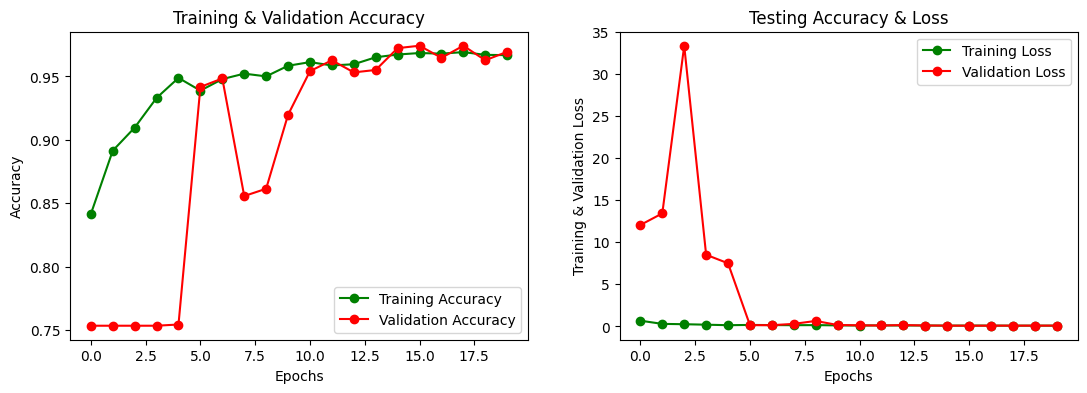

In [62]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(13,4)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [35]:
predictions = model.predict(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


array([1.8566950e-01, 4.4222059e-08, 1.2892001e-09, 9.6649042e-04,
       4.2652521e-01, 1.3832031e-15, 2.1053167e-04, 1.2904191e-02,
       3.7891705e-02, 4.0644804e-01, 5.0203630e-07, 6.3413113e-02,
       1.1141233e-01, 1.3552018e-05, 1.1159853e-01], dtype=float32)

In [38]:
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

In [39]:
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       390
           1       0.88      0.89      0.89       234

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



In [41]:
cm = confusion_matrix(y_test,binary_predictions)
cm

array([[361,  29],
       [ 25, 209]])

In [42]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

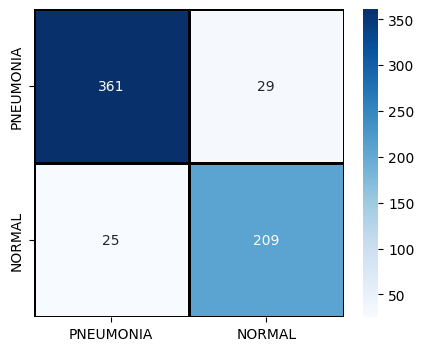

In [48]:
plt.figure(figsize = (5,4))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)